### imports

In [2]:
!pip install tensorflow
!pip install gensim
!pip install tf-keras

In [1067]:
import tensorflow as tf

from gensim.models import Word2Vec
from gensim.models import LsiModel
import gensim

import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sentence_transformers import SentenceTransformer
import json
import contractions
import random

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import copy


# maintIE inherent function clusters

#### analysing exceptions with inherent functions 

In [19]:
def analyse_inherent_function_exceptions(row, exception_type=None):

    # list of tuples of head and tail indices
    hasPart_heads = []
    hasPart_tails = []
    contains_heads =[]
    contains_tails =[]
    isA_relations_indices = []

    for r in row["relations"]:
        if r["type"] == "hasPart":
            hasPart_heads.append(r["head"])
            hasPart_tails.append(r["tail"])
        if r["type"] == "contains":
            contains_heads.append(r["head"])
            contains_tails.append(r["tail"])
        if r["type"] == "isA":
            isA_relations_indices.append((r["head"], r["tail"]))

    # remove any repeats
    hasPart_heads = list(set(hasPart_heads))
    hasPart_tails = list(set(hasPart_tails))
    
    # list of physical object indices not in a hasPart or isA relation
    physical_object_indices = []
    
    # get all physical object indices
    for i in range(len(row["entities"])):
        if row["entities"][i]["type"].split("/")[0] == "PhysicalObject":
            physical_object_indices.append(i)
    
    inherent_function_index = []
    for i in hasPart_tails:
        # if tail is not a head of a hasPart relation
        if i not in hasPart_heads:
            inherent_function_index.append(i)
        # remove tail from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)
    
    for i in hasPart_heads:
        # remove head from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)

    for i in isA_relations_indices:
        # remove physical objects that are part of an isA relation
        if i[0] in physical_object_indices:
            physical_object_indices.remove(i[0])
        if i[1] in physical_object_indices:
            physical_object_indices.remove(i[1])

    # EXCEPTION 1: if there are physical objects that are not part of a hasPart or isA relation
    if exception_type == "1":
        if physical_object_indices and inherent_function_index:
            print(row)
            for i in physical_object_indices:
                print(row["entities"][i])
            print()
    # EXCEPTION 2: if there is zero, or more than one physical object and no hasPart relation
    elif exception_type == "2":
        # count how many non substance physical objects there are
        ob = []
        for e in row["entities"]:
            if e["type"].split("/")[0] == "PhysicalObject" and (len(e["type"].split("/")) == 1 or (len(e["type"].split("/"))>1 and e["type"].split("/")[1]  != "Substance")):
                ob.append(e)

        if (len(inherent_function_index) == 0) and len(ob)!=1 and not isA_relations_indices:
            print(row)
            print("Number of non-substance Physical Objects:", len(ob))
            if ob:
                print(ob)
            print()
    # EXCEPTION 3: if there are more than one leftover tail from hasPart relations
    if exception_type == "3":
        if (len(inherent_function_index) > 1):
            print(row)
    # EXCEPTION 4: if the head and tail of an isA relation are not the same type
    if exception_type == "4":
        for i in isA_relations_indices:
            if row["entities"][i[0]]["type"] != row["entities"][i[1]]["type"]:
                print(row)
    return

f = open("../data/gold_release.json", "r")
# returns JSON object as a dictionary
data = json.load(f)
f.close()

except_type = input("Enter exception type: ")
MWO_by_function = {}

for datum in data:
    types = [e["type"].split("/")[0] for e in datum["entities"]]
    if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
        analyse_inherent_function_exceptions(datum, exception_type=except_type)

{'text': '<id> air leak', 'tokens': ['<id>', 'air', 'leak'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 2, 'end': 3, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]}
Number of non-substance Physical Objects: 0

{'text': '<id> auto-greaser leaking oil', 'tokens': ['<id>', 'auto-greaser', 'leaking', 'oil'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/GeneratingObject/LiquidFlowGeneratingObject'}, {'start': 2, 'end': 3, 'type': 'Process/UndesirableProcess'}, {'start': 3, 'end': 4, 'type': 'PhysicalObject/ProtectingObject/WearProtectingObject'}], 'relations': [{'head': 1, 'tail': 2, 'type': 'hasParticipant/hasPatient'}, {'head': 1, 'tail': 0, 'type': 'hasParticipant/hasAgent'}]}
Number of non-substance Physical Objects: 2
[{'start': 1, 'end': 2, 'type': 'PhysicalObject/GeneratingObject/LiquidFlowGeneratingObject'}, {'start': 3, 'end': 4, 'type': 'PhysicalObject/Pro

## Prepare Data

In [854]:
def extract_function_from_entity_index(row, index, equipment_dict=None):
    if equipment_dict:
        start = row["entities"][index]["start"]
        end = row["entities"][index]["end"]
        equipment = " ".join([row["tokens"][i] for i in range(start, end)])
        if equipment not in equipment_dict.keys():
            return None
        return equipment_dict[equipment][:-6].lower()
    types = row["entities"][index]["type"].split("/")
    if len(types) > 1:
        return types[1][:-6].lower()
    else:
        return None
    
def get_inherent_function(row, equipment_dict=None):

    # list of tuples of head and tail indices
    hasPart_heads = []
    hasPart_tails = []
    contains_heads =[]
    contains_tails =[]
    isA_relations_indices = []

    for r in row["relations"]:
        if r["type"] == "hasPart":
            hasPart_heads.append(r["head"])
            hasPart_tails.append(r["tail"])
        if r["type"] == "contains":
            contains_heads.append(r["head"])
            contains_tails.append(r["tail"])
        if r["type"] == "isA":
            isA_relations_indices.append((r["head"], r["tail"]))

    # remove any repeats
    hasPart_heads = list(set(hasPart_heads))
    hasPart_tails = list(set(hasPart_tails))
    
    # list of physical object indices not in a hasPart or isA relation
    physical_object_indices = []
    
    # get all physical object indices
    for i in range(len(row["entities"])):
        if row["entities"][i]["type"].split("/")[0] == "PhysicalObject" and (equipment_dict or len(row["entities"][i]["type"].split("/")) == 1 or (row["entities"][i]["type"].split("/")[1]  != "Substance")):
            physical_object_indices.append(i)
    
    inherent_function_index = []
    for i in hasPart_tails:
        # if tail is not a head of a hasPart relation
        if i not in hasPart_heads:
            inherent_function_index.append(i)
        # remove tail from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)
    
    for i in hasPart_heads:
        # remove head from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)

    for i in isA_relations_indices:
        # remove physical objects that are part of an isA relation
        if i[0] in physical_object_indices:
            physical_object_indices.remove(i[0])
        if i[1] in physical_object_indices:
            physical_object_indices.remove(i[1])

    # EXCEPTION 1: if there are physical objects that are not part of a hasPart or isA relation, and there is a hasPart relation
    if physical_object_indices and inherent_function_index:
        # in general, ignore additional physical objects 
        if len(inherent_function_index) ==1:
            isA_tails = [i[1] for i in isA_relations_indices]
            # if there is a more specific (head) object in an isA relation
            if inherent_function_index[0] in isA_tails:
                isA_head_index = isA_relations_indices[isA_tails.index(inherent_function_index[0])][0]
                func = extract_function_from_entity_index(row, isA_head_index, equipment_dict)
                return func
            else:
                func = extract_function_from_entity_index(row, inherent_function_index[0], equipment_dict)
                return func


    # EXCEPTION 2: if there is zero or more than one physical object and no hasPart relations
    if (len(inherent_function_index) == 0) and len(physical_object_indices)!=1 and not isA_relations_indices:
        # if there are no physical objects, remove the row
        if len(physical_object_indices) == 0:
            print("remove:",row, "\n")
            return None
        physical_object_not_substance = []
        for i in physical_object_indices:
            start = row["entities"][i]["start"]
            end = row["entities"][i]["end"]
            # if the physical object is not a substance
            if end == len(row["tokens"]) and " ".join(row["tokens"][start:]) != "oil":
                physical_object_not_substance.append(i)
            elif " ".join(row["tokens"][start:end]) != "oil":
                physical_object_not_substance.append(i)

        # if there is only one non-substance physical object, extract its function
        if len(physical_object_not_substance) == 1:
            func = extract_function_from_entity_index(row, physical_object_not_substance[0], equipment_dict)
            return func
        else:
            # !!! CHECK !!!
            # print(row)
            # print("Manually assign inherent function.")
            # print()
            # return "CHECK"
            func = extract_function_from_entity_index(row, physical_object_indices[0], equipment_dict)
            return func
            
                

    # EXCEPTION 3: if there are more than one leftover tail from hasPart relations
    if (len(inherent_function_index) > 1):
        # manually assign inherent function
        if row["text"] == "replace unserviceable transmission screen and magnet":
            return "transforming"
        elif row["text"] == "pump drive box coupling and shaft unserviceable":
            return "driving"
        else:
            return None
            # print(row)
            # raise Exception("Manually assign inherent function in Exception 3.")
    

    # get entities
    if len(inherent_function_index) == 1 and len(physical_object_indices) == 0:
        func = extract_function_from_entity_index(row, inherent_function_index[0], equipment_dict)
        return func
    elif len(inherent_function_index) == 0 and len(physical_object_indices) == 1:
        func = extract_function_from_entity_index(row, physical_object_indices[0], equipment_dict)
        return func
    elif all(i in [x for xs in isA_relations_indices for x in xs] for i in physical_object_indices):
        isA_heads = [i[0] for i in isA_relations_indices]
        isA_tails = [i[1] for i in isA_relations_indices]
        isA_specific_indices = []
        for i in isA_heads:
            if i not in isA_tails:
                isA_specific_indices.append(i)
        if len(isA_specific_indices) == 1:
            func = extract_function_from_entity_index(row, isA_specific_indices[0], equipment_dict)
            return func
        
        else:
            if row["text"] == "<id> park brake alarm fault":
                return "restricting"
            else:
                return None
                # print(row)
                # print("Manually assign inherent function.")
                # return "CHECK"
    elif len(inherent_function_index)>1:
        return None
        # print("SASDKDHAA")
        # return "CHECK"
    else:
        return None
        # print(row)
        # print("Manually assign inherent function.")
        # print()
        # return "CHECK"
    
    # for e in row["entities"]:
    #     entity_type = e["type"].split("/")
    #     if entity_type[0] == "PhysicalObject":
    #         if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
    #             if entity_type[1][:-6].lower() not in functions:
    #                 functions.append(entity_type[1][:-6].lower())
    # functions = ",".join(sorted(functions))
    # return functions

    # # EXCEPTION 4: if the head and tail of an isA relation are not the same type
    # if exception_type == 4:
    #     for i in isA_relations_indices:
    #         if row["entities"][i[0]]["type"] != row["entities"][i[1]]["type"]:
    #             print(row)


def get_gold_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    f = open("../data/gold_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()


    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            inherent_function = get_inherent_function(datum)
            if not inherent_function:
                continue

            tokens = datum["tokens"].copy()

            # remove activity tokens
            if "Activity" in types:
                activity_indices = []
                for e in datum["entities"]:
                    if e["type"].split("/")[0] == "Activity":
                        for i in range(e["start"], e["end"]):
                            activity_indices.append(i)
                activity_indices = sorted(set(activity_indices), reverse=True)
                for i in activity_indices:
                    tokens.pop(i)
                

            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            # add state, equipment, and inherent function to dictionary with key MWO
            mwo = " ".join(tokens)
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                for i in range(len(types)):
                    if types[i] in ["State", "Process", "Property"]:
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        states.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                    elif types[i] == "PhysicalObject":
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        equip.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]

    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()
    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO

In [995]:
def create_equipment_dictionary():
    f = open("../data/gold_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    
    # exception multiple types for the same equipment
    ignored_equipment = {"auto-lube":"ProtectingObject", "axle":"GuidingObject", "drag":"MatterProcessingObject", "universal joint":"GuidingObject", "adaptor":"InterfacingObject", "batteries":"StoringObject", "carousel":"StoringObject", "window":"RestrictingObject", "shaft":"GuidingObject", "input shaft":"GuidingObject"}
    equipment = ignored_equipment.copy()
    
    for datum in data:
        for e in datum["entities"]:
            entity_type = e["type"].split("/")
            if entity_type[0] == "PhysicalObject" and len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
                start = int(e["start"])
                end = int(e["end"])
                equipment_text = " ".join([datum["tokens"][t] for t in range(start, end)])
                
                if equipment_text in ignored_equipment:
                    continue
                if equipment_text not in equipment:
                    equipment[equipment_text] = entity_type[1]
                # elif equipment[equipment_text] != entity_type[1]:
                #     del equipment[equipment_text]
                    # ignored_equipment.append(equipment_text)
                    
                    # print("ERROR: Equipment text has multiple types")
                    # print(equipment_text)
                    # print(equipment[equipment_text])
                    # print(entity_type[1])
                    # print()
    return equipment

def get_synthetic_dataset(filename, dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    import csv


    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        counter = 0
        for row in csvreader:
            tokens = row[0].split()
            if len(row[1].split("/")) == 1 or row[1].split("/")[1] in ["Substance", "Organism", "GuidingObject","HoldingObject"] or "leak" in row[3]:
                counter+=1
                continue
            inherent_function = row[1].split("/")[1][:-6].lower()

            # # remove activity tokens
            # if "Activity" in types:
            #     activity_indices = []
            #     for e in datum["entities"]:
            #         if e["type"].split("/")[0] == "Activity":
            #             for i in range(e["start"], e["end"]):
            #                 activity_indices.append(i)
            #     activity_indices = sorted(set(activity_indices), reverse=True)
            #     for i in activity_indices:
            #         tokens.pop(i)
            
            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            mwo= " ".join(tokens)
            # add state, equipment, inherent function to dictionary with key tokens
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                states.append(row[3])
                equip.append(row[2])
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]

    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()

    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO
            
    
def get_silver_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    equipment_dict = create_equipment_dictionary()
    
    f = open("../data/silver_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            inherent_function = get_inherent_function(datum, equipment_dict)
            if not inherent_function:
                continue
            
            tokens = datum["tokens"].copy()

            # remove activity tokens
            if "Activity" in types:
                activity_indices = []
                for e in datum["entities"]:
                    if e["type"].split("/")[0] == "Activity":
                        for i in range(e["start"], e["end"]):
                            activity_indices.append(i)
                activity_indices = sorted(set(activity_indices), reverse=True)
                for i in activity_indices:
                    tokens.pop(i)
            
            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            mwo= " ".join(tokens)
            # add state, equipment, inherent function to dictionary with key tokens
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                for i in range(len(types)):
                    if types[i] in ["State", "Process", "Property"]:
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        states.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                    elif types[i] == "PhysicalObject":
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        equip.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]


    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()
    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO


In [1124]:
def create_dataset():
    MWO_by_function = {}
    dataset = []
    labels = []
    class_list = []
    state_equipment_inherentfunction_by_MWO = {}

    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_gold_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)
    # dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_synthetic_dataset("../data/synthetic.csv", dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)
    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_synthetic_dataset("../data/synthetic2.csv",dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)
    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_silver_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)

    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO


In [1125]:
dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = create_dataset()

# # balanced dataset 
# dataset = []
# labels = []
# random.seed(42)
# for i in range(17):
#     if class_list[i] == "informationprocessing": # CHECK INDEX class_list[i]
#         continue
#     dataset += random.sample(MWO_by_function[class_list[i]], min(len(MWO_by_function[class_list[i]]), 108))
#     labels += [i for j in range(min(len(MWO_by_function[class_list[i]]), 108))]


# remove information processing
for i in MWO_by_function["informationprocessing"]:
    if i in dataset:
        print("Removed")
        dataset.remove(i)
labels = [i for i in labels if i != 16] 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, random_state=42, shuffle=True, test_size=0.2)
y_train = np.array(y_train)
y_test = np.array(y_test)
X = X_train + X_test

print("training set length:",len( X_train))
print("test set length:", len(X_test))
print("dataset length:",len( dataset))

remove: {'text': '<id> air leak', 'tokens': ['<id>', 'air', 'leak'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 2, 'end': 3, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> - air leak', 'tokens': ['<id>', '-', 'air', 'leak'], 'entities': [{'start': 2, 'end': 3, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 3, 'end': 4, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> - fuel leak', 'tokens': ['<id>', '-', 'fuel', 'leak'], 'entities': [{'start': 2, 'end': 3, 'type': 'PhysicalObject/Substance/Liquid'}, {'start': 3, 'end': 4, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> <id> replace hydraulic oil leak text', 'tokens': ['<id>', '<id>', 'replace', 'hydraulic', 'oil', 

## Create Semantic embeddings

In [1076]:
def w2v_embed(xtrain,xtest, max_len):
    # Word2Vec embeddings as input
    x_copy_train = copy.deepcopy(xtrain)
    x_copy_test = copy.deepcopy(xtest)
    padded_x_train = pad_sequence(x_copy_train, max_len)
    padded_x_test = pad_sequence(x_copy_test, max_len)
    padded_x = padded_x_train + padded_x_test

    w2vmodel = gensim.models.Word2Vec(padded_x, min_count=1, vector_size=100,
                                    window=5, sg=1)


    w2v_embeddings_train = []
    for sentence in padded_x_train:
        row = []
        for word in sentence:
            row.append(w2vmodel.wv[word])
        w2v_embeddings_train.append(row)
    w2v_embeddings_train = np.array(w2v_embeddings_train)

    w2v_embeddings_test = []
    for sentence in padded_x_test:
        row = []
        for word in sentence:
            row.append(w2vmodel.wv[word])
        w2v_embeddings_test.append(row)
    w2v_embeddings_test = np.array(w2v_embeddings_test)
    return w2v_embeddings_train, w2v_embeddings_test

max_len = len(max(dataset, key=len))
w2v_embeddings_X_train, w2v_embeddings_X_test = w2v_embed(X_train, X_test, max_len)

print(w2v_embeddings_X_train.shape)
print(w2v_embeddings_X_test.shape)

['air', 'conditioner', 'thermostat', 'not', 'working']
max length of MWO: 10
max length of MWO: 10
(2520, 10, 100)
(631, 10, 100)
['air', 'conditioner', 'thermostat', 'not', 'working']


In [1126]:
# SBERT embeddings
sbert = SentenceTransformer("all-mpnet-base-v2")
SBERT_embeddings_train = sbert.encode(X_train)
SBERT_embeddings_test = sbert.encode(X_test)

print(SBERT_embeddings_train.shape)
print(SBERT_embeddings_test.shape)

/opt/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(2520, 768)
(631, 768)


In [228]:
def LSI_ebed(x):
    # LSI embeddings as output
    dictionary = gensim.corpora.Dictionary(x)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in x]
    lsamodel = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
    concepts = list(lsamodel[doc_term_matrix])
    lsa_embeddings=[]
    for i in concepts:
        row = []
        for j in i:
            row.append(j[1])
        lsa_embeddings.append(row)

    for i in range(len(lsa_embeddings)):
        if len(lsa_embeddings[i]) != 10:
            print(x[i])
    lsa_embeddings = np.array(lsa_embeddings)
    return lsa_embeddings



## Clustering Helper Functions

### K means

In [1141]:
def perform_kmeans(cluster_embeddings):
    # PCA reduction
    pca = PCA(n_components=2)
    pca_embedding = pca.fit_transform(cluster_embeddings)
    plt.scatter(pca_embedding[:,0], pca_embedding[:,1])
    plt.title("PCA")
    plt.show()

    # tsne reduction
    tsne = TSNE(n_components=2).fit_transform(cluster_embeddings)
    plt.scatter(tsne[:,0], tsne[:,1])
    plt.title("TSNE")
    plt.show()


    # Perform kmean clustering
    silhouette_scores = []
    test_k = list(range(5, 30))
    for i in test_k:
        print(i, "/", 30)
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=100).fit(cluster_embeddings)
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(cluster_embeddings, labels))
    plt.plot(test_k, silhouette_scores)
    plt.title("Silhouette Scores")
    plt.show()


def run_kmeans_best_k(k, cluster_embeddings):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100).fit(cluster_embeddings)
    cluster_labels = kmeans.labels_

    nmi = normalized_mutual_info_score(cluster_labels, y_train.tolist()+y_test.tolist())
    print("NMI:",nmi)

    for i in range(1,k+1):
        print("Cluster",i,":")
        cluster_words = {}
        cluster_states={}
        cluster_equip={}
        cluster_inherentfunc={}
        for j in range(len(cluster_labels)):
            if cluster_labels[j]==i:
                # print(" ".join(X[j]))
                for word in X[j]:
                    if word in cluster_words:
                        cluster_words[word]+=1
                    else:
                        cluster_words[word]=1
                mwo = " ".join(X[j])
                state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
                for state in state_equip_inherfunc[0]:
                    if state in cluster_states:
                        cluster_states[state]+=1
                    else:
                        cluster_states[state]=1
                for equip in state_equip_inherfunc[1]:
                    if equip in cluster_equip:
                        cluster_equip[equip]+=1
                    else:
                        cluster_equip[equip]=1
                if state_equip_inherfunc[2] in cluster_inherentfunc:
                    cluster_inherentfunc[state_equip_inherfunc[2]]+=1
                else:
                    cluster_inherentfunc[state_equip_inherfunc[2]]=1
        
        # get top words
        print("Cluster Size:", len(cluster_labels[cluster_labels==i]))
        print("Top words:")
        sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
        for j in range(min(len(sorted_cluster_words), 5)):
            print("  ",sorted_cluster_words[j])
        print()
        sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
        print("Top states:")
        for j in range(min(len(sorted_cluster_states), 5)):
            print("  ", sorted_cluster_states[j])
        print()

        sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
        print("Top equipment:")
        for j in range(min(len(sorted_cluster_equip), 5)):
            print("  ", sorted_cluster_equip[j])
        print()

        sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
        print("Inherent functions in order:")
        for j in range(len(sorted_cluster_inherentfunc)):
            print("  ",sorted_cluster_inherentfunc[j], cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
        print("=========================")

### Hierarchical Clustering

In [1142]:
def perform_hierarchical_clustering(cluster_embeddings, method):
    linkage_data = linkage(cluster_embeddings, method=method)
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(linkage_data)
    plt.show()

    # calculate sihouette score on different k values
    silhouette_scores = []
    test_k = list(range(5, 30))
    nmi = 0
    for i in test_k:
        cluster_labels = fcluster(linkage_data, i, criterion='maxclust')
        silhouette_scores.append(silhouette_score(cluster_embeddings, cluster_labels))
        if i == 16:
            nmi = normalized_mutual_info_score(cluster_labels, y_train.tolist()+y_test.tolist())
    plt.plot(test_k, silhouette_scores, marker='o')
    plt.title("Silhouette Scores")
    plt.show()

    print("NMI:",nmi)

    return linkage_data


def get_hierarchical_clusters(k, linkage_data):
    cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
    for i in range(1,k+1):
        print("Cluster",i,":")
        cluster_words = {}
        cluster_states={}
        cluster_equip={}
        cluster_inherentfunc={}
        for j in range(len(cluster_labels)):
            if cluster_labels[j]==i:
                for word in X[j]:
                    if word in cluster_words:
                        cluster_words[word]+=1
                    else:
                        cluster_words[word]=1
                mwo = " ".join(X[j])
                state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
                for state in state_equip_inherfunc[0]:
                    if state in cluster_states:
                        cluster_states[state]+=1
                    else:
                        cluster_states[state]=1
                for equip in state_equip_inherfunc[1]:
                    if equip in cluster_equip:
                        cluster_equip[equip]+=1
                    else:
                        cluster_equip[equip]=1
                if state_equip_inherfunc[2] in cluster_inherentfunc:
                    cluster_inherentfunc[state_equip_inherfunc[2]]+=1
                else:
                    cluster_inherentfunc[state_equip_inherfunc[2]]=1
        
        # get top words
        print("Cluster Size:", len(cluster_labels[cluster_labels==i]))
        print("Top words:")
        sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
        for j in range(min(len(sorted_cluster_words), 5)):
            print("  ",sorted_cluster_words[j])
        print()
        sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
        print("Top states:")
        for j in range(min(len(sorted_cluster_states), 5)):
            print("  ", sorted_cluster_states[j])
        print()

        sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
        print("Top equipment:")
        for j in range(min(len(sorted_cluster_equip), 5)):
            print("  ", sorted_cluster_equip[j])
        print()

        sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
        print("Inherent functions in order:")
        for j in range(len(sorted_cluster_inherentfunc)):
            print("  ",sorted_cluster_inherentfunc[j], cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
        print("=========================")

## w2v -> Inherent Function

### Create Cluster Embeddings

In [1144]:
# w2v_if_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(10,100)),
#     tf.keras.layers.Conv1D(128, 3, activation='relu'),
#     tf.keras.layers.MaxPool1D(3),
#     tf.keras.layers.Conv1D(128, 3, activation='relu'),
#     tf.keras.layers.MaxPool1D(3),
#     tf.keras.layers.Conv1D(128, 3, activation='relu'),
#     tf.keras.layers.GlobalMaxPool1D(),
#     tf.keras.layers.Dense(10, activation='relu'),
#     tf.keras.layers.Dense(16, activation='softmax')
# ])

# w2v_if_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (2,2), padding="same", input_shape=(10,100,1), use_bias=False),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation("relu"),
#     tf.keras.layers.MaxPool2D(pool_size=2),
#     # tf.keras.layers.Conv2D(8, (2,2), padding="same", use_bias=False),
#     # tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Activation("relu"),
#     # tf.keras.layers.MaxPool2D(pool_size=2),
    
#     tf.keras.layers.Flatten(),
#     # tf.keras.layers.Dense(units=128),
#     # tf.keras.layers.Activation("tanh"),
#     tf.keras.layers.Dense(units=10),
#     tf.keras.layers.Activation("tanh"),
#     tf.keras.layers.Dense(units=17, activation="softmax")
# ])
# w2v_if_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (2,2), padding="same", input_shape=(10,100,1), use_bias=False),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=64, activation="tanh"),
    
#     tf.keras.layers.Dense(units=10, activation="tanh"),
#     tf.keras.layers.Dense(units=16, activation="softmax")
# ])

w2v_if_model = tf.keras.Sequential([
    # tf.keras.layers.LSTM(64, input_shape=(10,100)),
    tf.keras.layers.Input(shape=(10,100)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(units=16, activation="softmax")
])
# model.summary()
# w2v_if_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(10,100,1)),
#     tf.keras.layers.MaxPool2D(pool_size=2),
#     tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
#     tf.keras.layers.MaxPool2D(pool_size=2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=10, activation="tanh"),
#     tf.keras.layers.Dense(units=16, activation="softmax")
# ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
class_weight = {}
for i in MWO_by_function.keys():
    class_weight[class_list.index(i)] = len(MWO_by_function[i])/len(dataset)

w2v_if_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
history = w2v_if_model.fit(w2v_embeddings_X_train, y_train, epochs=200, validation_data=(w2v_embeddings_X_test, y_test), callbacks=[early_stopping], class_weight=class_weight)

# run predictions
pred_train = w2v_if_model.predict(w2v_embeddings_X_train)
pred_train = pred_train.argmax(axis=-1)
print("Final train accuracy:", w2v_if_model.evaluate(w2v_embeddings_X_train, y_train)[1])

pred_test = w2v_if_model.predict(w2v_embeddings_X_test)
pred_test = pred_test.argmax(axis=-1)
print("Final test accuracy:", w2v_if_model.evaluate(w2v_embeddings_X_test, y_test)[1])

Epoch 1/200
79/79 [==============================] - 5s 17ms/step - loss: 0.1859 - accuracy: 0.2266 - val_loss: 2.2637 - val_accuracy: 0.3090
Epoch 2/200
79/79 [==============================] - 1s 7ms/step - loss: 0.1380 - accuracy: 0.3631 - val_loss: 2.0946 - val_accuracy: 0.3883
Epoch 3/200
79/79 [==============================] - 1s 7ms/step - loss: 0.1191 - accuracy: 0.4333 - val_loss: 1.9264 - val_accuracy: 0.4089
Epoch 4/200
79/79 [==============================] - 1s 6ms/step - loss: 0.1054 - accuracy: 0.4837 - val_loss: 1.8438 - val_accuracy: 0.4628
Epoch 5/200
79/79 [==============================] - 1s 6ms/step - loss: 0.0966 - accuracy: 0.5183 - val_loss: 1.9075 - val_accuracy: 0.4295
Epoch 6/200
79/79 [==============================] - 1s 8ms/step - loss: 0.0906 - accuracy: 0.5480 - val_loss: 1.6601 - val_accuracy: 0.5357
Epoch 7/200
79/79 [==============================] - 1s 7ms/step - loss: 0.0837 - accuracy: 0.5917 - val_loss: 1.6941 - val_accuracy: 0.5293
Epoch 8/200


In [1146]:
# get hidden layer model 
# w2v_if_model_embedding = tf.keras.Sequential([
    
#     tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(10,100,1)),
#     tf.keras.layers.MaxPool2D(pool_size=2),
#     tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
#     tf.keras.layers.MaxPool2D(pool_size=2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=10, activation="tanh"),
# ])
w2v_if_model_embedding = tf.keras.Sequential([
    # tf.keras.layers.LSTM(64, input_shape=(10,100)),
    tf.keras.layers.Input(shape=(10,100)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu')
])

# w2v_if_model_embedding.layers[0].set_weights(w2v_if_model.layers[0].get_weights())
# w2v_if_model_embedding.layers[2].set_weights(w2v_if_model.layers[2].get_weights())
# w2v_if_model_embedding.layers[5].set_weights(w2v_if_model.layers[5].get_weights())

w2v_if_model_embedding.layers[0].set_weights(w2v_if_model.layers[0].get_weights())
w2v_if_model_embedding.layers[1].set_weights(w2v_if_model.layers[1].get_weights())
w2v_if_model_embedding.layers[2].set_weights(w2v_if_model.layers[2].get_weights())
w2v_if_model_embedding.layers[3].set_weights(w2v_if_model.layers[3].get_weights())


w2v_embeddings = np.concatenate((w2v_embeddings_X_train, w2v_embeddings_X_test))
cluster_embeddings = w2v_if_model_embedding.predict(w2v_embeddings)
print(cluster_embeddings.shape)


99/99 [==============================] - 1s 2ms/step
(3151, 10)


### K-means

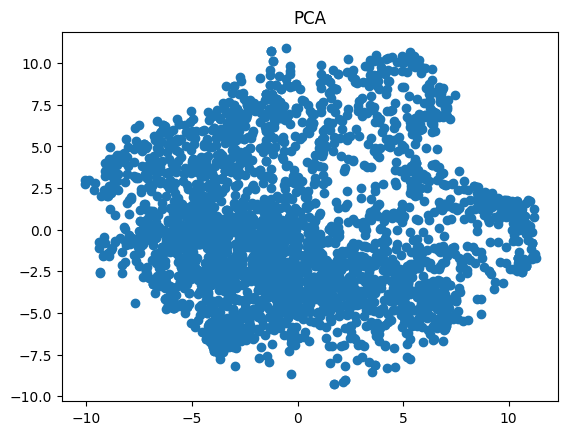

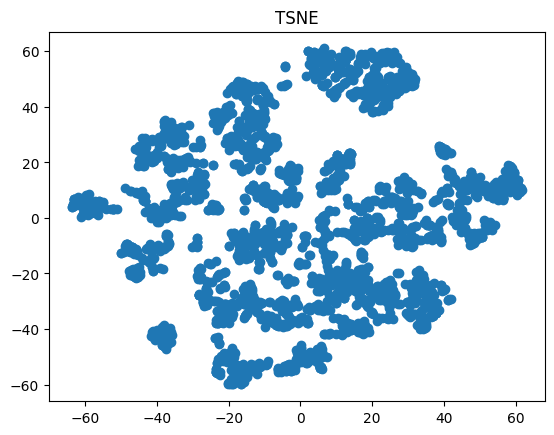

5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30


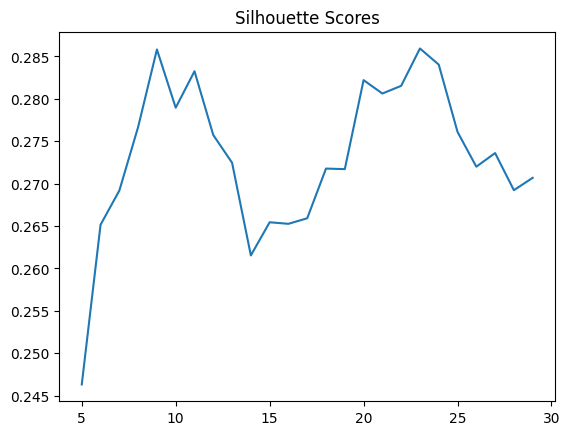

In [1147]:
perform_kmeans(cluster_embeddings)

In [1148]:
run_kmeans_best_k(9, cluster_embeddings)

NMI: 0.523958093617919
Cluster 1 :
Cluster Size: 673
Top words:
   broken
   cracked
   window
   hand
   cabin

Top states:
   broken
   cracked
   crack
   missing
   worn

Top equipment:
   window
   door
   oil
   bucket
   tank

Inherent functions in order:
   controlling 180
   protecting 96
   matterprocessing 93
   storing 87
   holding 72
   covering 41
   interfacing 35
   restricting 31
   humaninteraction 12
   guiding 10
   presenting 7
   transforming 2
   sensing 2
   generating 2
   emitting 2
   driving 1
Cluster 2 :
Cluster Size: 241
Top words:
   leak
   oil
   fuse
   system
   grease

Top states:
   leak
   fault
   keeps blowing
   found
   keep blowing

Top equipment:
   oil
   coolant
   grease system
   hydraulic oil
   pump

Inherent functions in order:
   protecting 197
   generating 7
   controlling 5
   presenting 5
   transforming 5
   holding 5
   driving 4
   emitting 3
   storing 3
   interfacing 3
   matterprocessing 2
   guiding 1
   covering 1
Cluste

### Ave Hierarchical

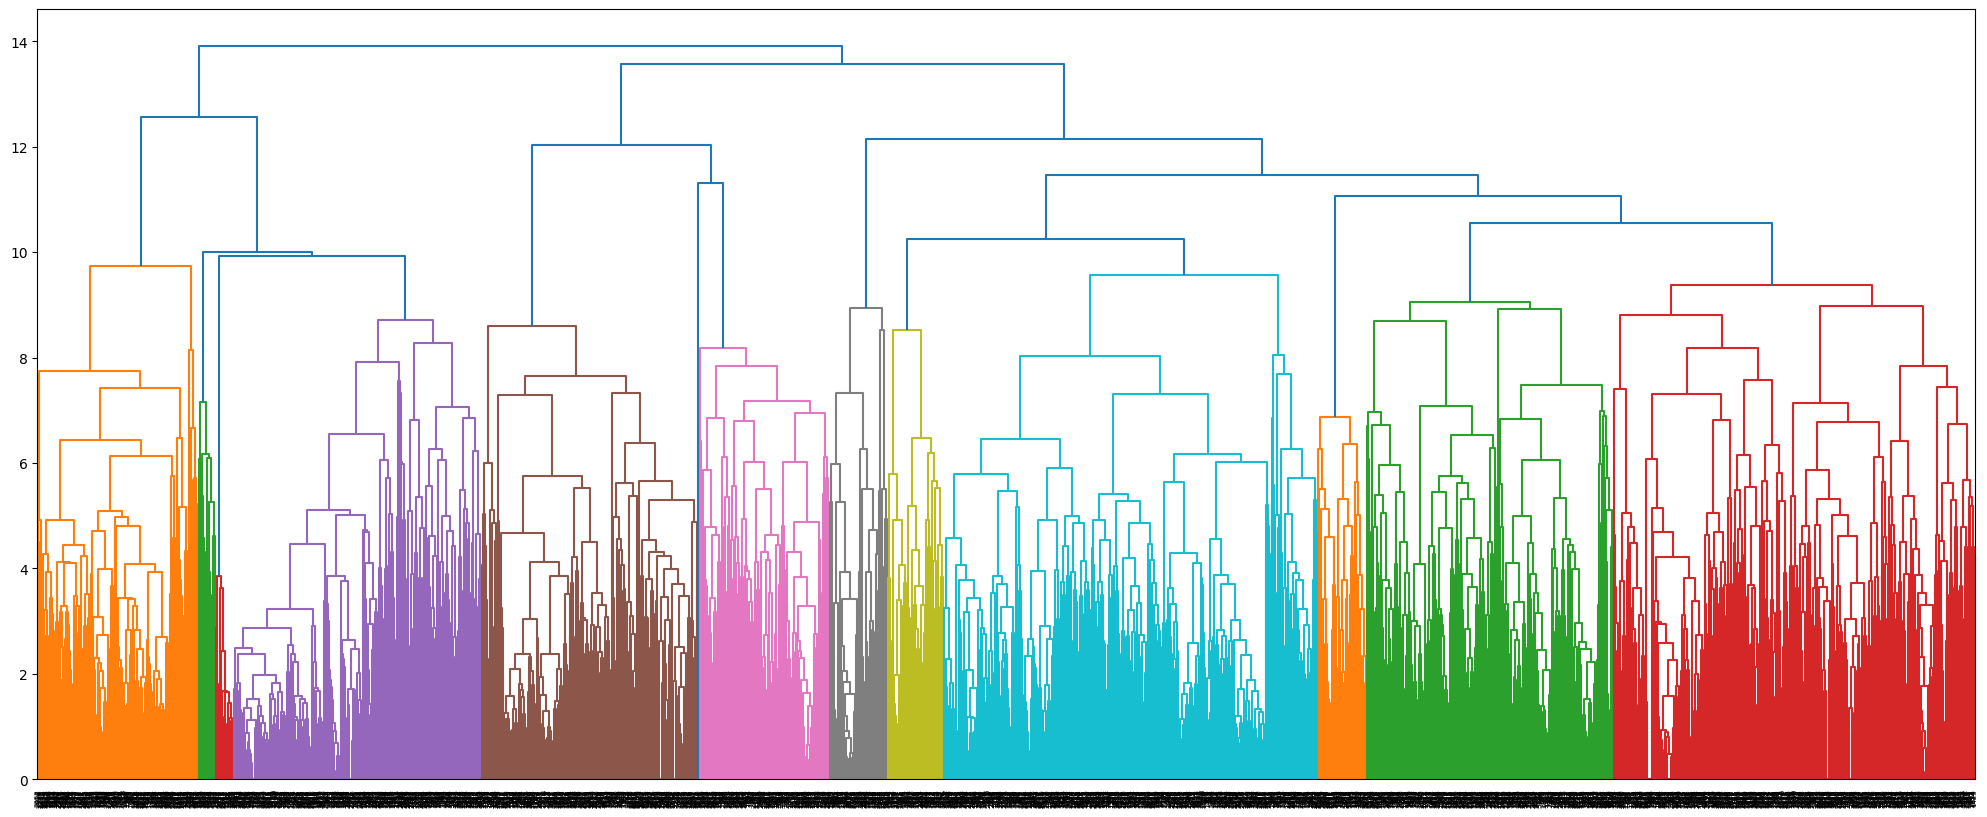

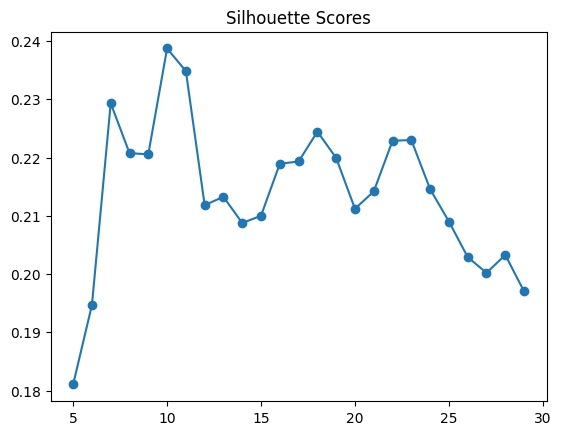

NMI: 0.5149832052793822


In [1149]:
linkage_data_ave = perform_hierarchical_clustering(cluster_embeddings, "average")

In [1151]:
get_hierarchical_clusters(10, linkage_data_ave)

Cluster 1 :
Cluster Size: 262
Top words:
   missing
   bolts
   pin
   broken
   hand

Top states:
   missing
   broken
   loose
   unserviceable
   coming out

Top equipment:
   bolts
   pin
   bolt
   bearing
   rope

Inherent functions in order:
   holding 229
   controlling 8
   covering 7
   transforming 4
   storing 4
   guiding 3
   interfacing 2
   matterprocessing 1
   restricting 1
   sensing 1
   protecting 1
   presenting 1
Cluster 2 :
Cluster Size: 461
Top words:
   hose
   blown
   position
   leaking
   tyre

Top states:
   blown
   leaking
   unserviceable
   damaged
   broken

Top equipment:
   hose
   tyre
   brake
   steering
   pulley

Inherent functions in order:
   guiding 388
   covering 41
   holding 8
   generating 5
   interfacing 5
   driving 4
   protecting 3
   storing 2
   controlling 2
   presenting 1
   restricting 1
   transforming 1
Cluster 3 :
Cluster Size: 351
Top words:
   air
   conditioner
   light
   lights
   out

Top states:
   out
   unservice

In [1152]:
get_hierarchical_clusters(18, linkage_data_ave)

Cluster 1 :
Cluster Size: 245
Top words:
   missing
   bolts
   pin
   broken
   hand

Top states:
   missing
   broken
   loose
   unserviceable
   coming out

Top equipment:
   bolts
   pin
   bolt
   bearing
   rope

Inherent functions in order:
   holding 222
   covering 6
   transforming 3
   storing 3
   guiding 2
   interfacing 2
   controlling 2
   matterprocessing 1
   restricting 1
   sensing 1
   protecting 1
   presenting 1
Cluster 2 :
Cluster Size: 17
Top words:
   steering
   transmission
   main
   breaker
   ropes

Top states:
   tripped
   require
   damaged
   falling off
   stripped

Top equipment:
   transmission
   steering
   ropes
   circuit breaker
   air tanks

Inherent functions in order:
   holding 7
   controlling 6
   storing 1
   transforming 1
   guiding 1
   covering 1
Cluster 3 :
Cluster Size: 28
Top words:
   belt
   air
   conditioner
   unserviceable
   wiring

Top states:
   unserviceable
   missing
   loose
   requires
   damaged

Top equipment:
  

### Ward Hierarchical

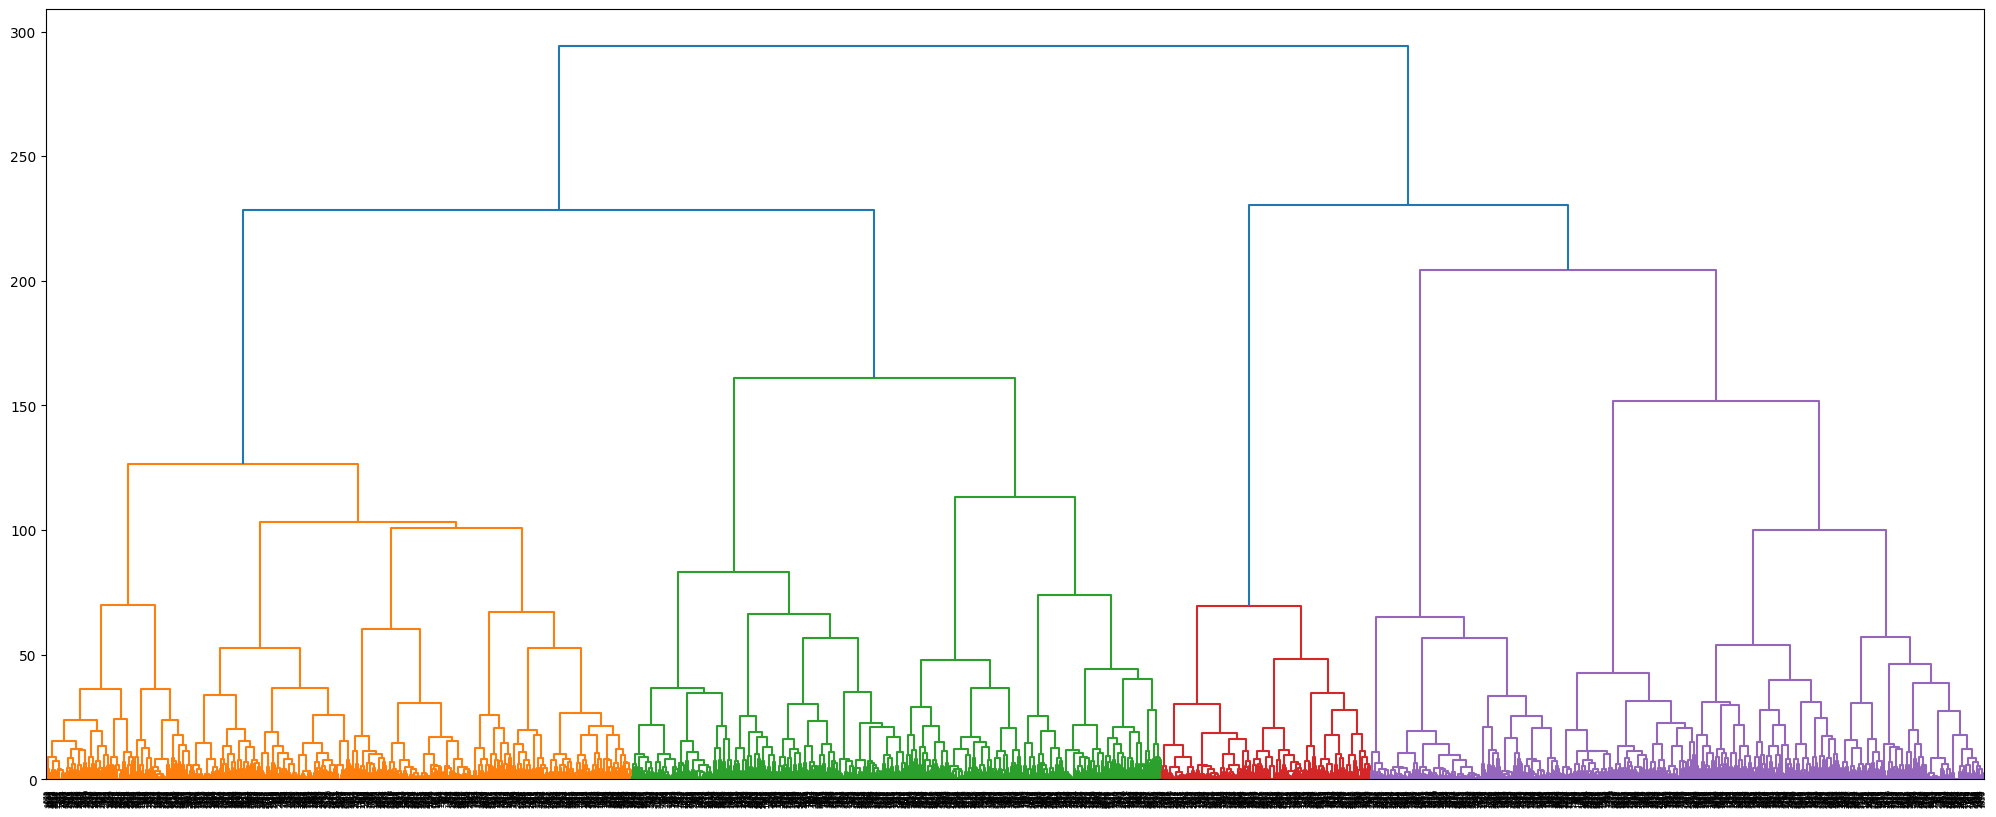

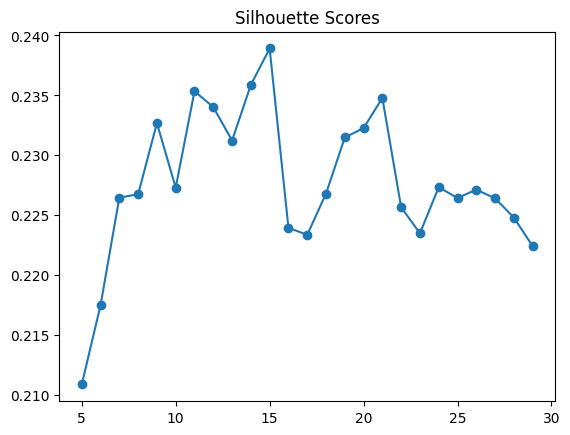

NMI: 0.5144121711074586


In [1150]:
linkage_data_ward = perform_hierarchical_clustering(cluster_embeddings, "ward")

In [1153]:
get_hierarchical_clusters(15, linkage_data_ward)

Cluster 1 :
Cluster Size: 144
Top words:
   leak
   oil
   coolant
   engine
   pump

Top states:
   leak
   found
   leaks
   needs repair
   leaking

Top equipment:
   oil
   coolant
   engine
   hydraulic oil
   pump

Inherent functions in order:
   protecting 102
   interfacing 9
   transforming 7
   covering 5
   holding 4
   matterprocessing 3
   presenting 3
   generating 3
   emitting 2
   driving 2
   guiding 1
   restricting 1
   controlling 1
   storing 1
Cluster 2 :
Cluster Size: 93
Top words:
   fuse
   system
   blowing
   fault
   air

Top states:
   fault
   keeps blowing
   keep blowing
   weeping
   faults

Top equipment:
   grease system
   fuse
   operator cabin air conditioner fuse
   fire system
   pressure compensator

Inherent functions in order:
   protecting 88
   holding 2
   generating 1
   emitting 1
   driving 1
Cluster 3 :
Cluster Size: 260
Top words:
   missing
   fuel
   worn
   bucket
   filter

Top states:
   missing
   worn
   broken
   crack
   leak

In [1154]:
get_hierarchical_clusters(21, linkage_data_ward)

Cluster 1 :
Cluster Size: 144
Top words:
   leak
   oil
   coolant
   engine
   pump

Top states:
   leak
   found
   leaks
   needs repair
   leaking

Top equipment:
   oil
   coolant
   engine
   hydraulic oil
   pump

Inherent functions in order:
   protecting 102
   interfacing 9
   transforming 7
   covering 5
   holding 4
   matterprocessing 3
   presenting 3
   generating 3
   emitting 2
   driving 2
   guiding 1
   restricting 1
   controlling 1
   storing 1
Cluster 2 :
Cluster Size: 93
Top words:
   fuse
   system
   blowing
   fault
   air

Top states:
   fault
   keeps blowing
   keep blowing
   weeping
   faults

Top equipment:
   grease system
   fuse
   operator cabin air conditioner fuse
   fire system
   pressure compensator

Inherent functions in order:
   protecting 88
   holding 2
   generating 1
   emitting 1
   driving 1
Cluster 3 :
Cluster Size: 260
Top words:
   missing
   fuel
   worn
   bucket
   filter

Top states:
   missing
   worn
   broken
   crack
   leak

## SBERT -> Inherent Function

### Create Cluster Embeddings

In [1128]:
sbert_if_model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(units=128, activation="tanh", input_shape=(768,)),
    tf.keras.layers.Dense(units=64, activation="tanh"),
    tf.keras.layers.Dense(units=32, activation="tanh"),

    tf.keras.layers.Dense(units=10, activation="tanh"),
    tf.keras.layers.Dense(units=16, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
class_weight = {}
for i in MWO_by_function.keys():
    class_weight[class_list.index(i)] = len(MWO_by_function[i])/len(dataset)

sbert_if_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
history = sbert_if_model.fit(SBERT_embeddings_train, y_train, epochs=200, validation_data=(SBERT_embeddings_test, y_test), callbacks=[early_stopping], class_weight=class_weight)

# do predictions
pred_train = sbert_if_model.predict(SBERT_embeddings_train)
pred_train = pred_train.argmax(axis=-1)
print("training accuracy", sbert_if_model.evaluate(SBERT_embeddings_train, y_train)[1])

pred_test = sbert_if_model.predict(SBERT_embeddings_test)
pred_test = pred_test.argmax(axis=-1)
print("test accuracy", sbert_if_model.evaluate(SBERT_embeddings_test, y_test)[1])


Epoch 1/200
79/79 [==============================] - 1s 3ms/step - loss: 0.1954 - accuracy: 0.2417 - val_loss: 2.4061 - val_accuracy: 0.2837
Epoch 2/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1598 - accuracy: 0.3524 - val_loss: 2.3042 - val_accuracy: 0.3550
Epoch 3/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1441 - accuracy: 0.4000 - val_loss: 2.1976 - val_accuracy: 0.3883
Epoch 4/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1336 - accuracy: 0.4405 - val_loss: 2.2123 - val_accuracy: 0.3883
Epoch 5/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1263 - accuracy: 0.4639 - val_loss: 2.1469 - val_accuracy: 0.4136
Epoch 6/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1206 - accuracy: 0.4933 - val_loss: 2.0870 - val_accuracy: 0.4358
Epoch 7/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1153 - accuracy: 0.5107 - val_loss: 2.0844 - val_accuracy: 0.4453
Epoch 8/200
7

In [1130]:
# get hidden layer model 
sbert_if_model_embedding = tf.keras.Sequential([
    
    tf.keras.layers.Dense(units=128, activation="tanh", input_shape=(768,)),
    tf.keras.layers.Dense(units=64, activation="tanh"),
    tf.keras.layers.Dense(units=32, activation="tanh"),

    tf.keras.layers.Dense(units=10, activation="tanh"),
    # tf.keras.layers.Dense(units=16, activation="softmax")
])


sbert_if_model_embedding.layers[0].set_weights(sbert_if_model.layers[0].get_weights())
sbert_if_model_embedding.layers[1].set_weights(sbert_if_model.layers[1].get_weights())
sbert_if_model_embedding.layers[2].set_weights(sbert_if_model.layers[2].get_weights())
sbert_if_model_embedding.layers[3].set_weights(sbert_if_model.layers[3].get_weights())
# sbert_if_model_embedding.layers[4].set_weights(sbert_if_model.layers[4].get_weights())


SBERT_embeddings = np.concatenate((SBERT_embeddings_train, SBERT_embeddings_test))
cluster_embeddings = sbert_if_model_embedding.predict(SBERT_embeddings)
print(cluster_embeddings.shape)


99/99 [==============================] - 0s 596us/step
(3151, 10)


### K-means

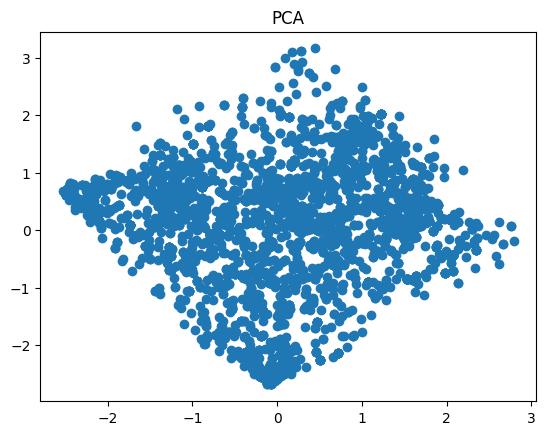

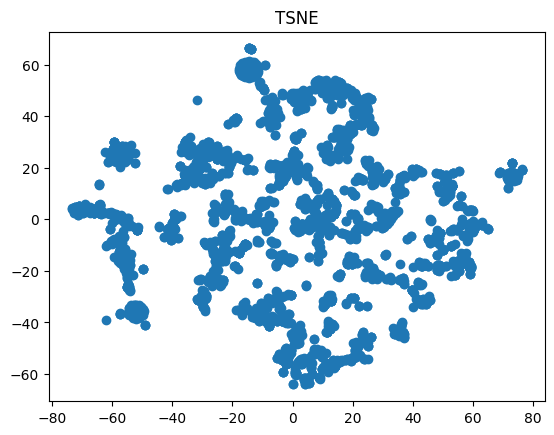

5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30


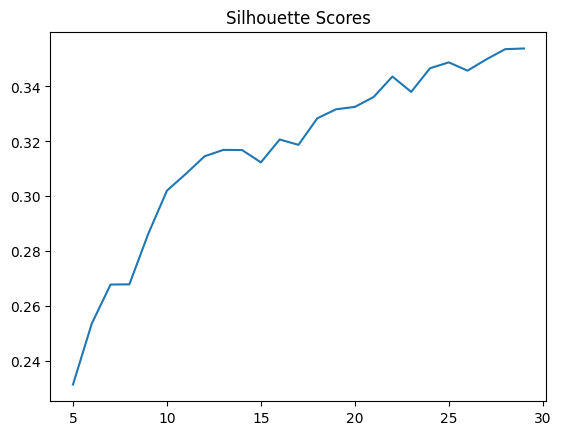

In [1131]:
perform_kmeans(cluster_embeddings)

In [1134]:
run_kmeans_best_k(13, cluster_embeddings)

NMI: 0.4300123761787568
Cluster 1 :
Cluster Size: 184
Top words:
   engine
   oil
   motor
   fault
   leak

Top states:
   fault
   leak
   unserviceable
   vibration
   overheating

Top equipment:
   engine
   oil
   motor
   hoist
   pump

Inherent functions in order:
   driving 120
   transforming 11
   sensing 10
   protecting 10
   interfacing 9
   guiding 6
   generating 5
   covering 4
   matterprocessing 3
   presenting 3
   holding 2
   restricting 1
Cluster 2 :
Cluster Size: 269
Top words:
   broken
   missing
   pin
   bolts
   out

Top states:
   broken
   missing
   unserviceable
   loose
   leak

Top equipment:
   pin
   bolts
   bearing
   bolt
   cabin

Inherent functions in order:
   holding 217
   transforming 8
   interfacing 7
   covering 6
   matterprocessing 5
   controlling 5
   guiding 4
   storing 3
   protecting 3
   presenting 3
   emitting 3
   sensing 2
   driving 2
   humaninteraction 1
Cluster 3 :
Cluster Size: 203
Top words:
   oil
   leak
   in
   crac

### Ave Hierachical

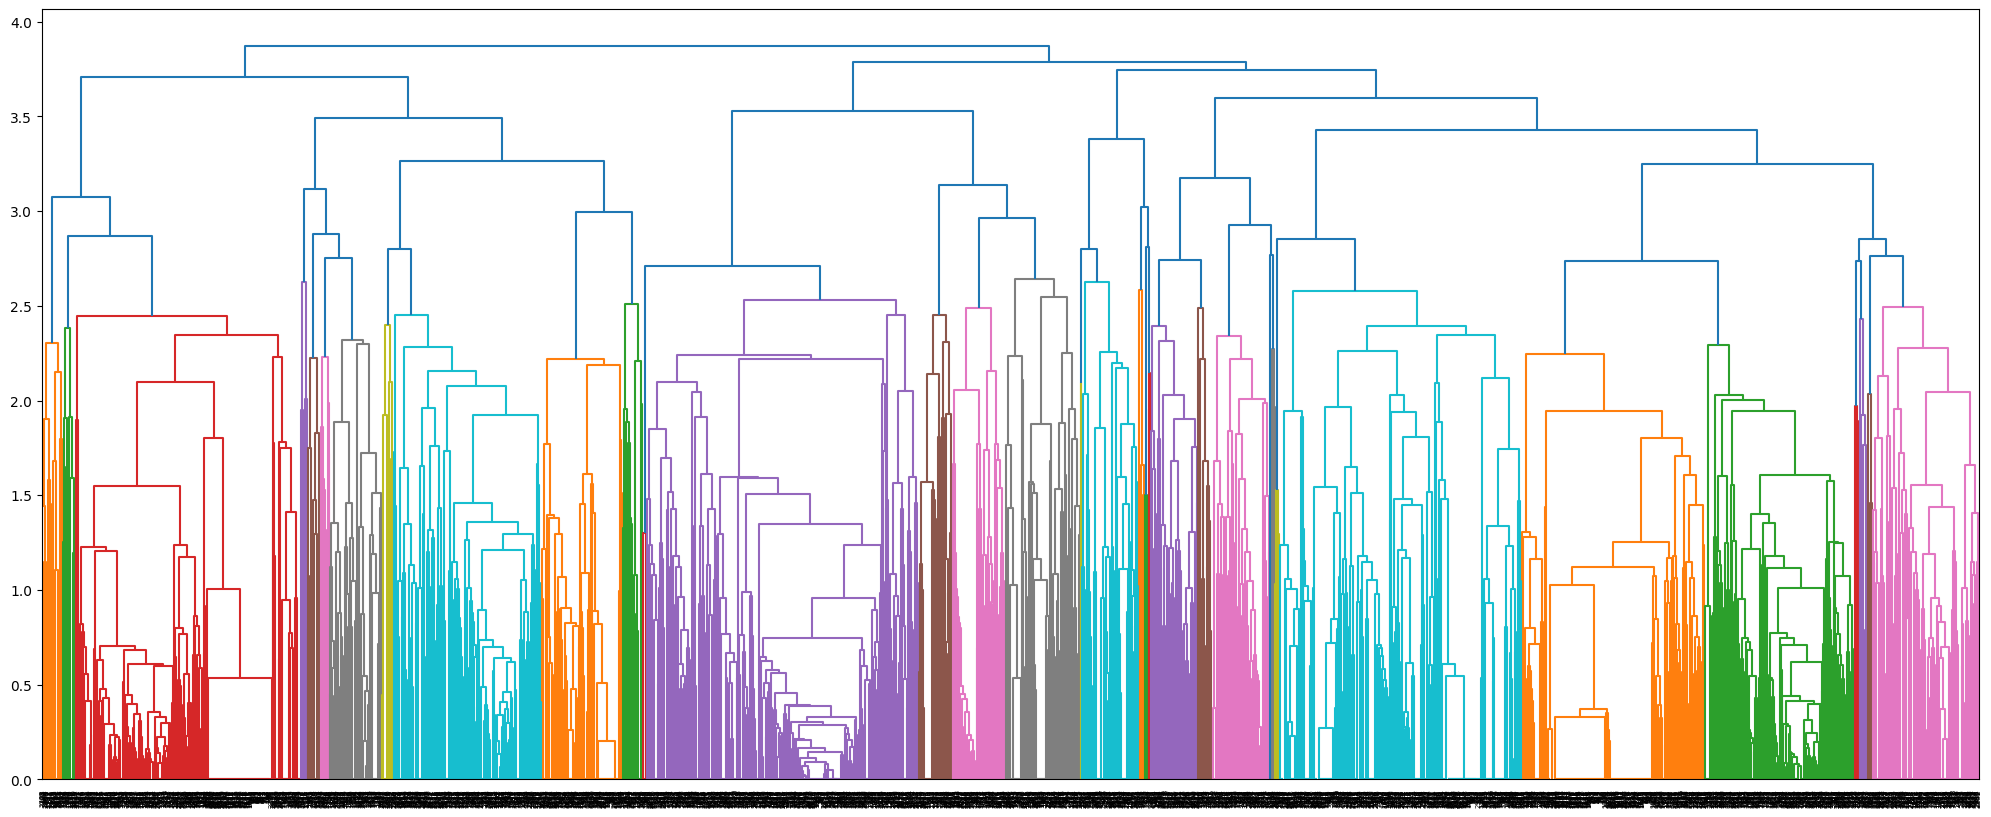

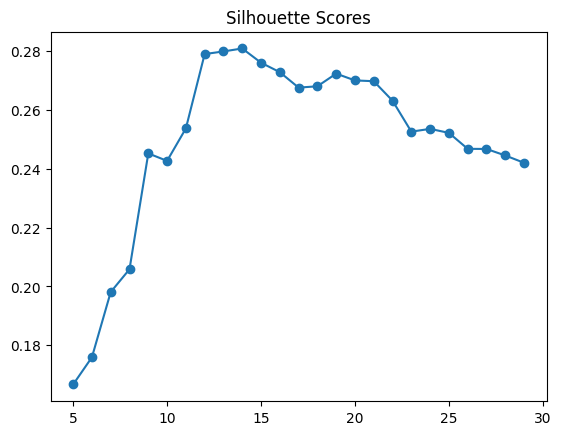

NMI: 0.4336973827647308


In [1133]:
linkage_data_ave = perform_hierarchical_clustering(cluster_embeddings, "average")

In [1135]:
get_hierarchical_clusters(14, linkage_data_ave)

Cluster 1 :
Cluster Size: 421
Top words:
   air
   conditioner
   unserviceable
   light
   out

Top states:
   unserviceable
   out
   not working
   leaking
   blown

Top equipment:
   air conditioner
   lights
   light
   radiator
   compressor

Inherent functions in order:
   emitting 280
   generating 35
   covering 21
   guiding 16
   controlling 14
   sensing 12
   protecting 9
   matterprocessing 7
   presenting 5
   restricting 5
   driving 5
   storing 4
   holding 3
   transforming 2
   humaninteraction 2
   interfacing 1
Cluster 2 :
Cluster Size: 132
Top words:
   pump
   not
   unserviceable
   working
   contamination

Top states:
   unserviceable
   not working
   on
   leak
   faulty

Top equipment:
   horn
   air horn
   pump
   depth counter
   filter

Inherent functions in order:
   sensing 61
   presenting 23
   generating 16
   matterprocessing 10
   interfacing 6
   restricting 4
   transforming 4
   controlling 2
   driving 1
   covering 1
   storing 1
   emittin

In [1137]:
get_hierarchical_clusters(19, linkage_data_ave)

Cluster 1 :
Cluster Size: 34
Top words:
   air
   replace
   leak
   conditioner
   brake

Top states:
   leak
   blown
   leaking
   worn
   needs

Top equipment:
   air
   brake
   air conditioner
   tank
   seal

Inherent functions in order:
   covering 7
   emitting 6
   protecting 4
   restricting 4
   matterprocessing 3
   controlling 3
   guiding 3
   storing 2
   presenting 1
   holding 1
Cluster 2 :
Cluster Size: 387
Top words:
   air
   conditioner
   unserviceable
   light
   out

Top states:
   unserviceable
   out
   not working
   fault
   leaking

Top equipment:
   air conditioner
   lights
   light
   radiator
   compressor

Inherent functions in order:
   emitting 274
   generating 35
   covering 14
   guiding 13
   sensing 12
   controlling 11
   protecting 5
   driving 5
   presenting 4
   matterprocessing 4
   transforming 2
   humaninteraction 2
   storing 2
   holding 2
   restricting 1
   interfacing 1
Cluster 3 :
Cluster Size: 11
Top words:
   number
   air
   f

### Ward Hierarchical

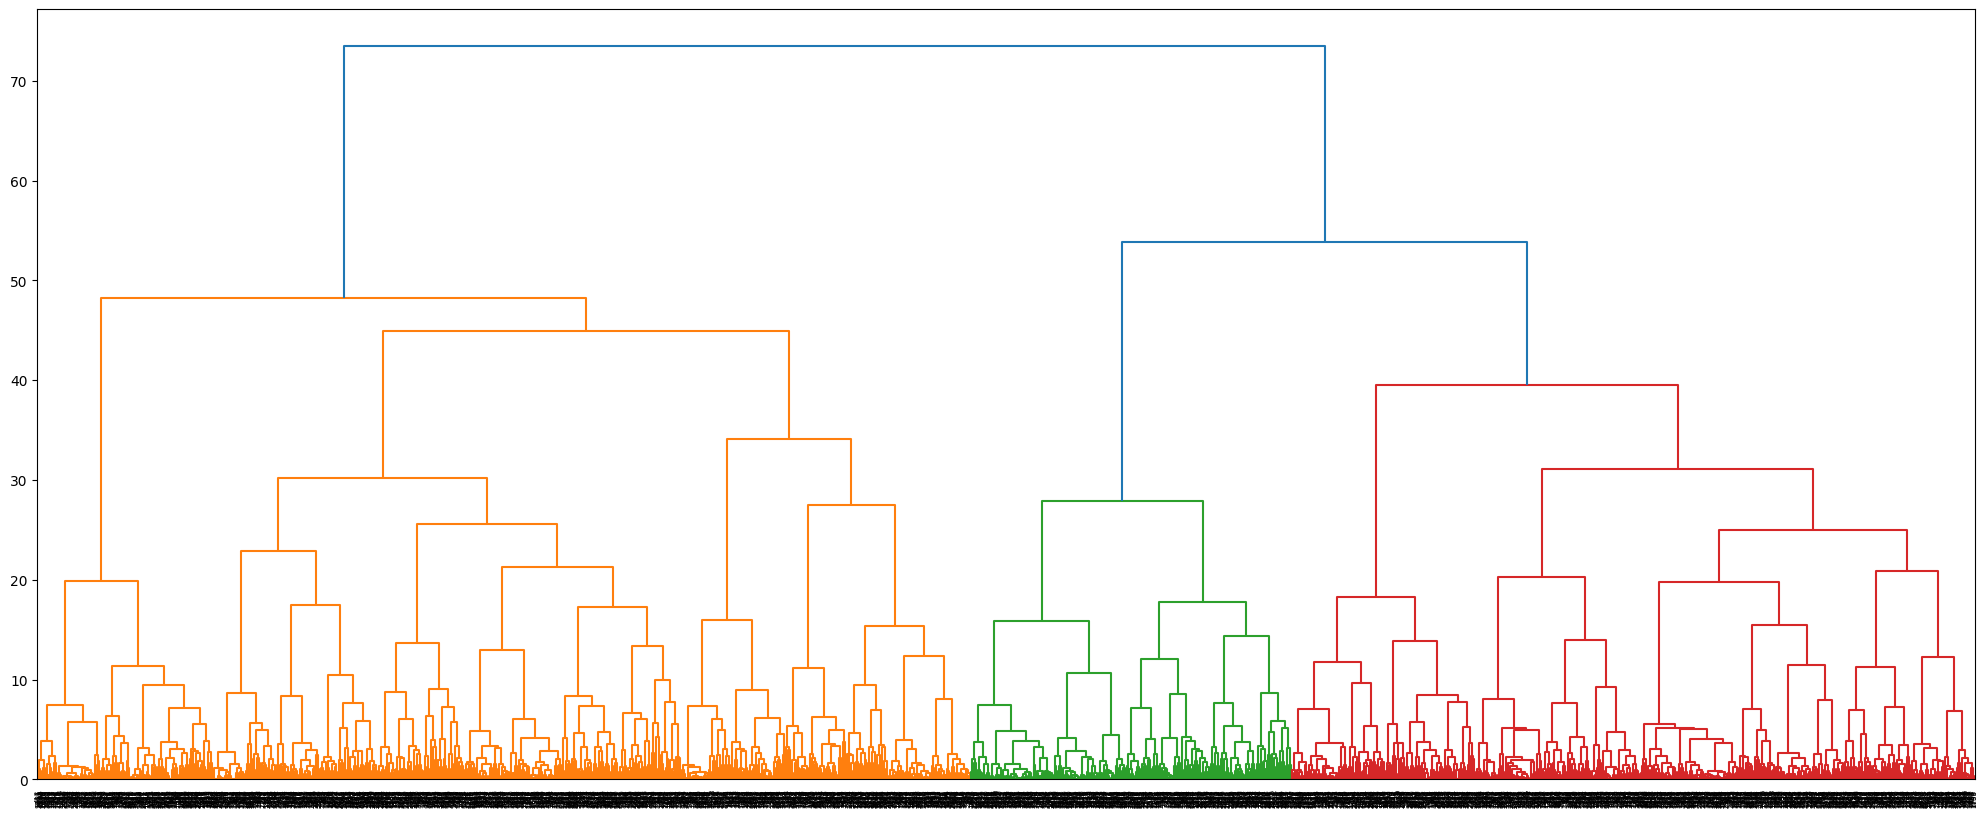

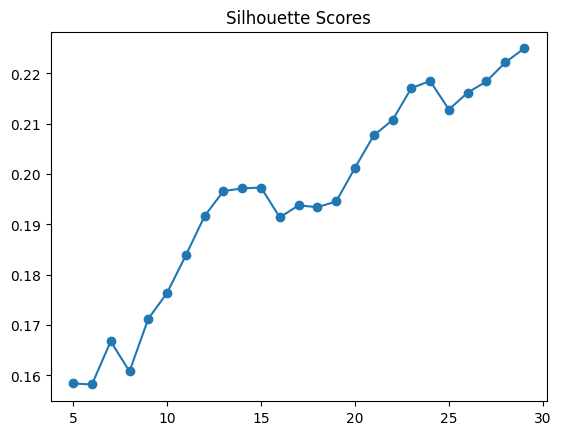

NMI: 0.4515083374946283


In [1122]:
linkage_data_ward = perform_hierarchical_clustering(cluster_embeddings, "ward")

In [1112]:
get_hierarchical_clusters(15, linkage_data_ward)

Cluster 1 :
Cluster Size: 285
Top words:
   unserviceable
   broken
   hand
   leaking
   brake

Top states:
   unserviceable
   broken
   leaking
   leak
   fault

Top equipment:
   hose
   brake
   air conditioner
   oil
   engine

Inherent functions in order:
   guiding 47
   holding 33
   emitting 30
   protecting 29
   controlling 22
   generating 20
   driving 20
   storing 15
   transforming 13
   restricting 11
   covering 10
   matterprocessing 10
   interfacing 9
   presenting 7
   sensing 5
   humaninteraction 4
Cluster 2 :
Cluster Size: 104
Top words:
   hand
   unserviceable
   in
   hose
   crack

Top states:
   unserviceable
   crack
   blown
   leaking
   leak

Top equipment:
   hose
   brake
   engine
   fuel tank
   coolant

Inherent functions in order:
   guiding 18
   holding 15
   protecting 12
   generating 7
   storing 7
   driving 6
   restricting 6
   covering 6
   emitting 6
   presenting 5
   controlling 4
   matterprocessing 3
   sensing 3
   humaninteractio

In [1113]:
get_hierarchical_clusters(24, linkage_data_ward)

Cluster 1 :
Cluster Size: 104
Top words:
   unserviceable
   hand
   broken
   brake
   leak

Top states:
   unserviceable
   broken
   leak
   leaking
   not working

Top equipment:
   hose
   air conditioner
   brake
   drag
   oil

Inherent functions in order:
   guiding 16
   holding 16
   protecting 12
   emitting 10
   controlling 9
   generating 8
   driving 7
   matterprocessing 6
   storing 5
   restricting 5
   covering 3
   transforming 3
   humaninteraction 2
   sensing 1
   interfacing 1
Cluster 2 :
Cluster Size: 181
Top words:
   broken
   fault
   unserviceable
   leaking
   brake

Top states:
   broken
   fault
   unserviceable
   leaking
   leak

Top equipment:
   brake
   hose
   engine
   oil
   light

Inherent functions in order:
   guiding 31
   emitting 20
   holding 17
   protecting 17
   driving 13
   controlling 13
   generating 12
   transforming 10
   storing 10
   interfacing 8
   presenting 7
   covering 7
   restricting 6
   sensing 4
   matterprocessing 4